# 🧱 DCGAN - Bricks Data

In this notebook, we'll walk through the steps required to train your own DCGAN on the bricks dataset

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..")))
from notebooks.utils import display, sample_batch

2026-02-12 20:56:43.421703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-12 20:56:43.594159: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-12 20:56:43.602069: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-02-12 20:56:43.602089: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

## 0. Parameters <a name="parameters"></a>

In [2]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 256
Z_DIM = 100
EPOCHS = 10
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

## 1. Prepare the data <a name="prepare"></a>

In [ ]:
train_data = utils.image_dataset_from_directory(
    "/root/autodl-tmp/AIGC/data/dataset",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 8189 files belonging to 1 classes.


2026-02-12 20:56:46.141130: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-02-12 20:56:46.141348: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2026-02-12 20:56:46.141495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2026-02-12 20:56:46.141631: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2026-02-12 20:56:46.334778: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

In [4]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [5]:
train_sample = sample_batch(train)

In [6]:
display(train_sample)

## 2. Build the GAN <a name="build"></a>

In [7]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                             

In [8]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        2097

In [9]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [10]:
# Create a DCGAN
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [11]:
if LOAD_MODEL:
    dcgan.load_weights("./checkpoint/checkpoint.ckpt")

## 3. Train the GAN <a name="train"></a>

In [12]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [13]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )

Epoch 1/10


32/32 [==============================] - ETA: 0s - d_loss: 0.2819 - d_real_acc: 0.8336 - d_fake_acc: 0.7959 - d_acc: 0.8148 - g_loss: 3.1594 - g_acc: 0.2041
Saved to ./output/generated_img_000.png


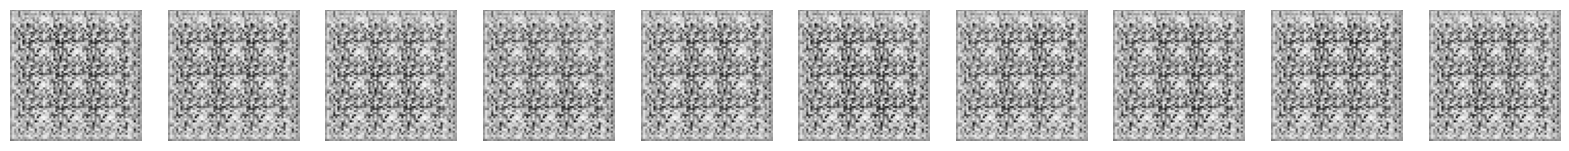

32/32 [==============================] - 59s 2s/step - d_loss: 0.2819 - d_real_acc: 0.8336 - d_fake_acc: 0.7959 - d_acc: 0.8148 - g_loss: 3.1594 - g_acc: 0.2041
Epoch 2/10
32/32 [==============================] - ETA: 0s - d_loss: 0.2742 - d_real_acc: 0.8030 - d_fake_acc: 0.8304 - d_acc: 0.8167 - g_loss: 4.3006 - g_acc: 0.1696
Saved to ./output/generated_img_001.png


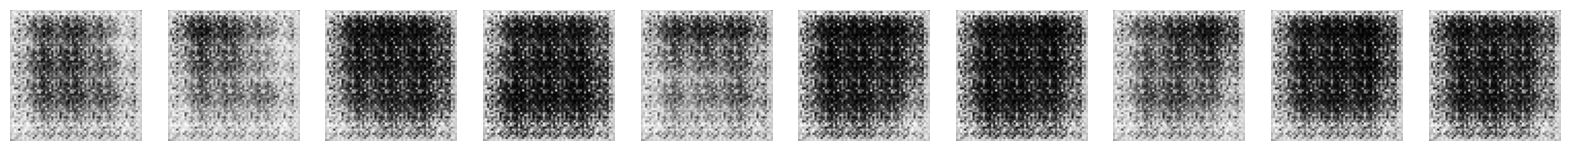

32/32 [==============================] - 55s 2s/step - d_loss: 0.2742 - d_real_acc: 0.8030 - d_fake_acc: 0.8304 - d_acc: 0.8167 - g_loss: 4.3006 - g_acc: 0.1696
Epoch 3/10
32/32 [==============================] - ETA: 0s - d_loss: 0.4011 - d_real_acc: 0.7470 - d_fake_acc: 0.8351 - d_acc: 0.7911 - g_loss: 1.8832 - g_acc: 0.1649
Saved to ./output/generated_img_002.png


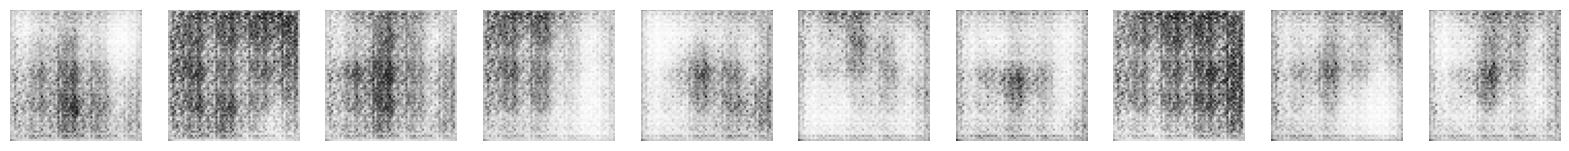

32/32 [==============================] - 55s 2s/step - d_loss: 0.4011 - d_real_acc: 0.7470 - d_fake_acc: 0.8351 - d_acc: 0.7911 - g_loss: 1.8832 - g_acc: 0.1649
Epoch 4/10
32/32 [==============================] - ETA: 0s - d_loss: 0.2277 - d_real_acc: 0.8221 - d_fake_acc: 0.8880 - d_acc: 0.8550 - g_loss: 2.3206 - g_acc: 0.1120
Saved to ./output/generated_img_003.png


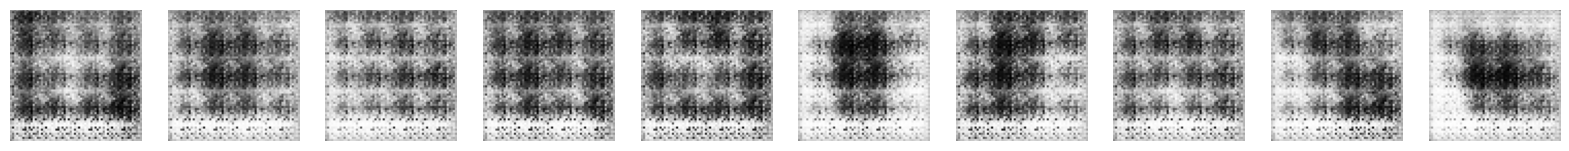

32/32 [==============================] - 55s 2s/step - d_loss: 0.2277 - d_real_acc: 0.8221 - d_fake_acc: 0.8880 - d_acc: 0.8550 - g_loss: 2.3206 - g_acc: 0.1120
Epoch 5/10
32/32 [==============================] - ETA: 0s - d_loss: 0.2388 - d_real_acc: 0.8288 - d_fake_acc: 0.8740 - d_acc: 0.8514 - g_loss: 2.8527 - g_acc: 0.1260
Saved to ./output/generated_img_004.png


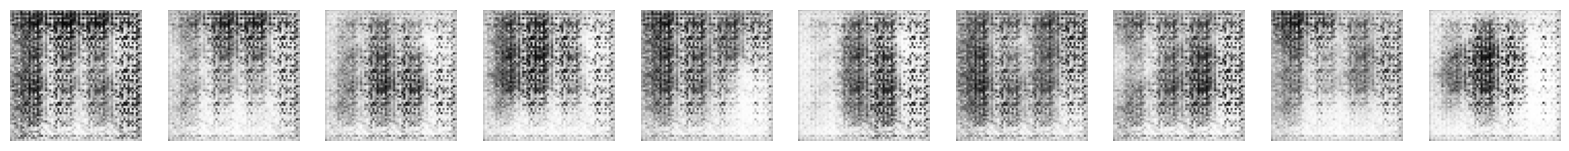

32/32 [==============================] - 55s 2s/step - d_loss: 0.2388 - d_real_acc: 0.8288 - d_fake_acc: 0.8740 - d_acc: 0.8514 - g_loss: 2.8527 - g_acc: 0.1260
Epoch 6/10
32/32 [==============================] - ETA: 0s - d_loss: 0.4525 - d_real_acc: 0.7635 - d_fake_acc: 0.7769 - d_acc: 0.7702 - g_loss: 2.3046 - g_acc: 0.2231
Saved to ./output/generated_img_005.png


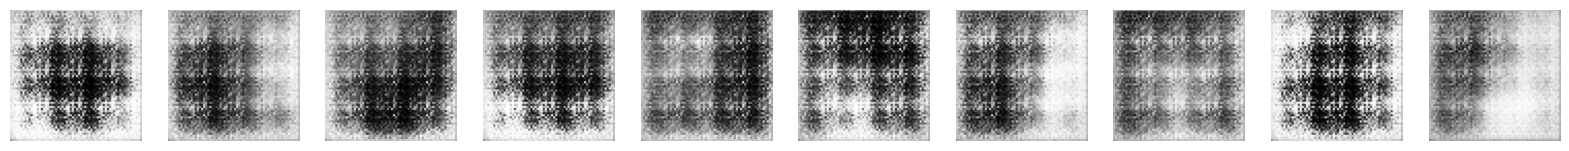

32/32 [==============================] - 56s 2s/step - d_loss: 0.4525 - d_real_acc: 0.7635 - d_fake_acc: 0.7769 - d_acc: 0.7702 - g_loss: 2.3046 - g_acc: 0.2231
Epoch 7/10
32/32 [==============================] - ETA: 0s - d_loss: 0.5267 - d_real_acc: 0.6968 - d_fake_acc: 0.7428 - d_acc: 0.7198 - g_loss: 1.5949 - g_acc: 0.2572
Saved to ./output/generated_img_006.png


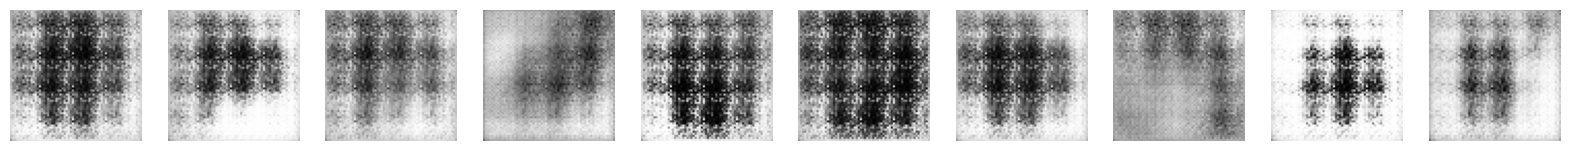

32/32 [==============================] - 55s 2s/step - d_loss: 0.5267 - d_real_acc: 0.6968 - d_fake_acc: 0.7428 - d_acc: 0.7198 - g_loss: 1.5949 - g_acc: 0.2572
Epoch 8/10
32/32 [==============================] - ETA: 0s - d_loss: 0.4716 - d_real_acc: 0.7370 - d_fake_acc: 0.7511 - d_acc: 0.7440 - g_loss: 1.4902 - g_acc: 0.2489
Saved to ./output/generated_img_007.png


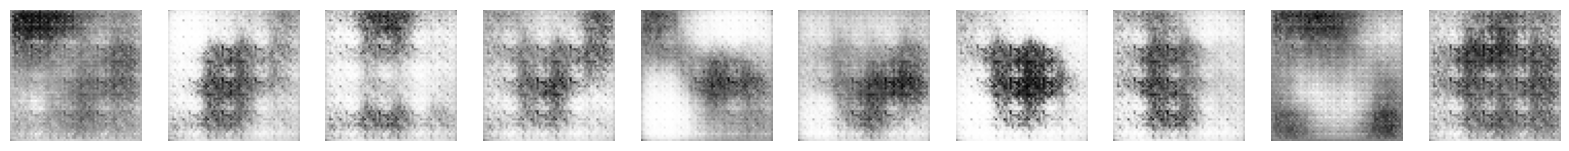

32/32 [==============================] - 56s 2s/step - d_loss: 0.4716 - d_real_acc: 0.7370 - d_fake_acc: 0.7511 - d_acc: 0.7440 - g_loss: 1.4902 - g_acc: 0.2489
Epoch 9/10
32/32 [==============================] - ETA: 0s - d_loss: 0.3899 - d_real_acc: 0.7714 - d_fake_acc: 0.8050 - d_acc: 0.7882 - g_loss: 1.7194 - g_acc: 0.1950
Saved to ./output/generated_img_008.png


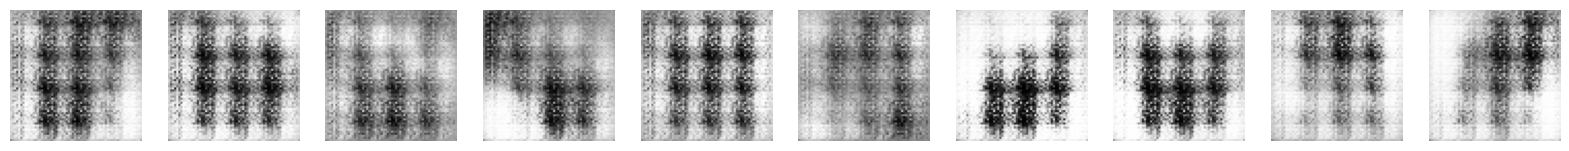

32/32 [==============================] - 55s 2s/step - d_loss: 0.3899 - d_real_acc: 0.7714 - d_fake_acc: 0.8050 - d_acc: 0.7882 - g_loss: 1.7194 - g_acc: 0.1950
Epoch 10/10
32/32 [==============================] - ETA: 0s - d_loss: 0.3737 - d_real_acc: 0.7741 - d_fake_acc: 0.8176 - d_acc: 0.7958 - g_loss: 1.8876 - g_acc: 0.1824
Saved to ./output/generated_img_009.png


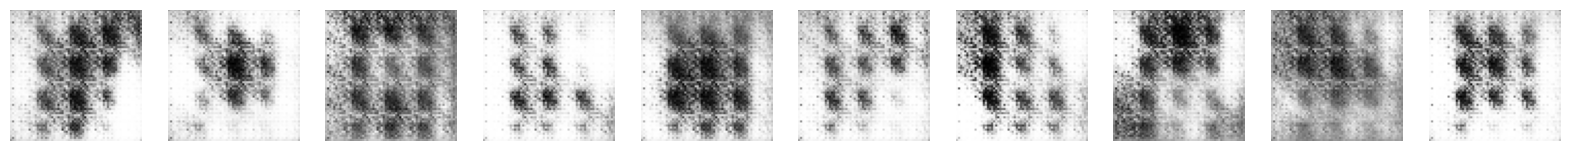

32/32 [==============================] - 55s 2s/step - d_loss: 0.3737 - d_real_acc: 0.7741 - d_fake_acc: 0.8176 - d_acc: 0.7958 - g_loss: 1.8876 - g_acc: 0.1824


In [14]:
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [15]:
# Save the final models
generator.save("./models/generator")
discriminator.save("./models/discriminator")

INFO:tensorflow:Assets written to: ./models/generator/assets


INFO:tensorflow:Assets written to: ./models/generator/assets


INFO:tensorflow:Assets written to: ./models/discriminator/assets


INFO:tensorflow:Assets written to: ./models/discriminator/assets


## 3. Generate new images <a name="decode"></a>

In [16]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [17]:
# Decode the sampled points
reconstructions = generator.predict(z_sample)

1/1 [==============================] - 0s 225ms/step


In [18]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [19]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [20]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

In [21]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

1/1 [==============================] - 0s 50ms/step


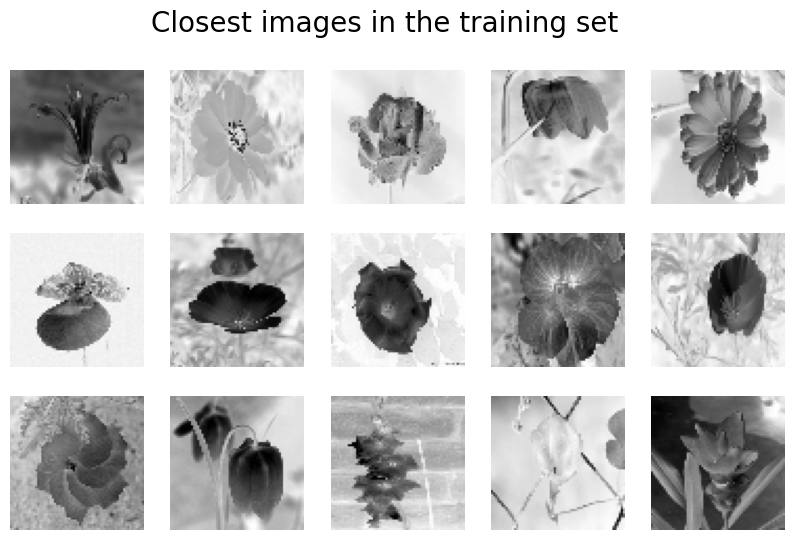

In [22]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()